In [1]:
#@title Imports
import os
import random
import sys
import torch
import torchvision

from diffusers import AutoencoderKL

if os.path.exists("../iadb.py"):
    sys.path.append("..") # use local src
else:
    !git clone https://github.com/pharmapsychotic/iadb-fun
    sys.path.append("iadb-fun") # use github src

import iadb

In [3]:
#@title Load a pre-trained model
config_path = "cats/cats64.yaml"
model_path = "cats/cats64_219086.ckpt"

config = iadb.config_load(config_path)
model = iadb.model_from_config(config)
iadb.model_load_weights(model, model_path)
resolution = config.get('resolution', 64)
uses_vae = config.get('vae_latents', False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if uses_vae:
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
    vae = vae.eval().to(device)
else:
    vae = None

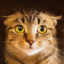

In [7]:
#@title Image creation

#@markdown Settings
seed = -1 #@param {type:"integer"}
steps = 32 #@param {type:"integer"}
batch_size = 1 #@param {type:"integer"}
sampler = "rk4" #@param ["euler", "rk4"]

# seed with given value or pick one at random if -1
seed = random.randint(0, 2**32-1) if seed == -1 else seed
torch.manual_seed(seed)

# create random starting gaussian noise
if vae:
    x0 = torch.randn(batch_size, 4, resolution//8, resolution//8, device=device)
else:
    x0 = torch.randn(batch_size, 3, resolution, resolution, device=device)

# use the model to map from distribution of gaussian noise to distribution of images
if sampler == "euler":
    samples = iadb.sample_euler(model, x0, steps)
else:
    samples = iadb.sample_runge_kutta(model, x0, steps)

# decode VAE latents if needed
if vae:
    with torch.no_grad():
        samples = vae.decode(1/0.18215 * samples).sample

# remap from -1,1 to 0,1
samples = samples.mul(0.5).add(0.5).clamp(0, 1).cpu()

# display images
for i in range(batch_size):
    image = torchvision.transforms.functional.to_pil_image(samples[i])
    display(image)
